# In-painting pipeline for Stable Diffusion using 🧨 Diffusers

This notebook shows how to do text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

In [ ]:
# !pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

To use private and gated models on 🤗 Hugging Face Hub, login is required. If you are only using a public checkpoint (such as `runwayml/stable-diffusion-inpainting` in this notebook), you can skip this step.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
# from diffusers import (
#     StableDiffusionPipeline,
#     StableDiffusionImg2ImgPipeline,
#     StableDiffusionInpaintPipeline,
# )

# text2img = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
# img2img = StableDiffusionImg2ImgPipeline(**text2img.components)
# inpaint = StableDiffusionInpaintPipeline(**text2img.components)

# # now you can use text2img(...), img2img(...), inpaint(...) just like the call methods of each respective pipeline

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    safety_checker = None,
    requires_safety_checker = False
).to(device)

text_encoder\model.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

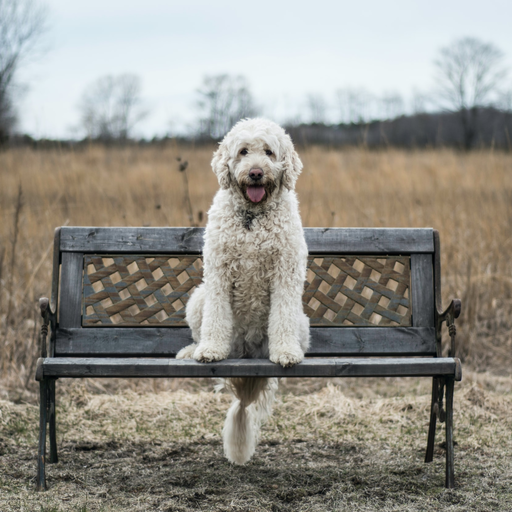

In [ ]:
image = download_image(img_url).resize((512, 512))
image

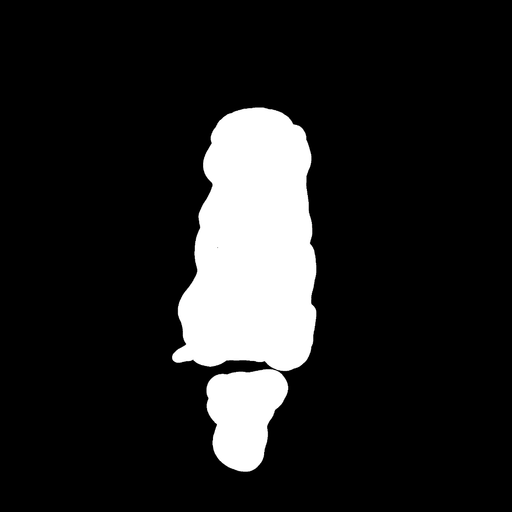

In [ ]:
mask_image = download_image(mask_url).resize((512, 512))
mask_image

In [ ]:
# prompt = "a mecha robot sitting on a bench"

# guidance_scale=7.5
# num_samples = 3
# generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

# images = pipe(
#     prompt=prompt,
#     image=image,
#     mask_image=mask_image,
#     guidance_scale=guidance_scale,
#     generator=generator,
#     num_images_per_prompt=num_samples,
# ).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# image = download_image(img_url).resize((512, 512))
# image
from PIL import Image
image = Image.open("sample_data/scene_00010.png")
image

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
# mask_image = download_image(mask_url).resize((512, 512))
# np.array(mask_image)
# mask_image = mask_image.resize((960, 540), Image.Resampling.LANCZOS)


mask_image = Image.open("sample_data/mask_00010.png")
mask_image = mask_image.resize((512, 512), Image.Resampling.LANCZOS)
a = np.array(mask_image)[:,:,:3]

# # Find where any of R, G, or B is not 0
non_zero_mask = np.any(a != 0, axis=-1)*1.0
# print(non_zero_mask)
# # # Set those pixels to 255 for all RGB channels
# a[non_zero_mask] = 255
# # # print(a.shape)
# mask_image = Image.fromarray(a)

# # # Convert the image to grayscale
# # gray_image = mask_image.convert('L')
# # Convert the image to a numpy array
# image_array = np.array(gray_image)

# Define the kernel for dilation
kernel = np.ones((5,5), np.uint8)  # Adjust kernel size as needed

# Apply dilation
dilated_array = cv2.dilate(non_zero_mask, kernel, iterations=1)
print(dilated_array)
# Convert the dilated numpy array back to a PIL image
dilated_image = Image.fromarray(dilated_array*255)
# plt.imshow(dilated_image)

# Convert the single-channel image to a 3-channel image with only black and white pixels
bw_image = dilated_image.convert('1') 
mask_image = bw_image
# mask_image = dilated_image
# print(mask_image)

# # print(image.size)
# print(mask_image.size)

mask_image

NameError: name 'Image' is not defined

In [ ]:
# prompt = "natural background"
prompt = "inpainting based on the surrounding"

guidance_scale = 7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

In [ ]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)


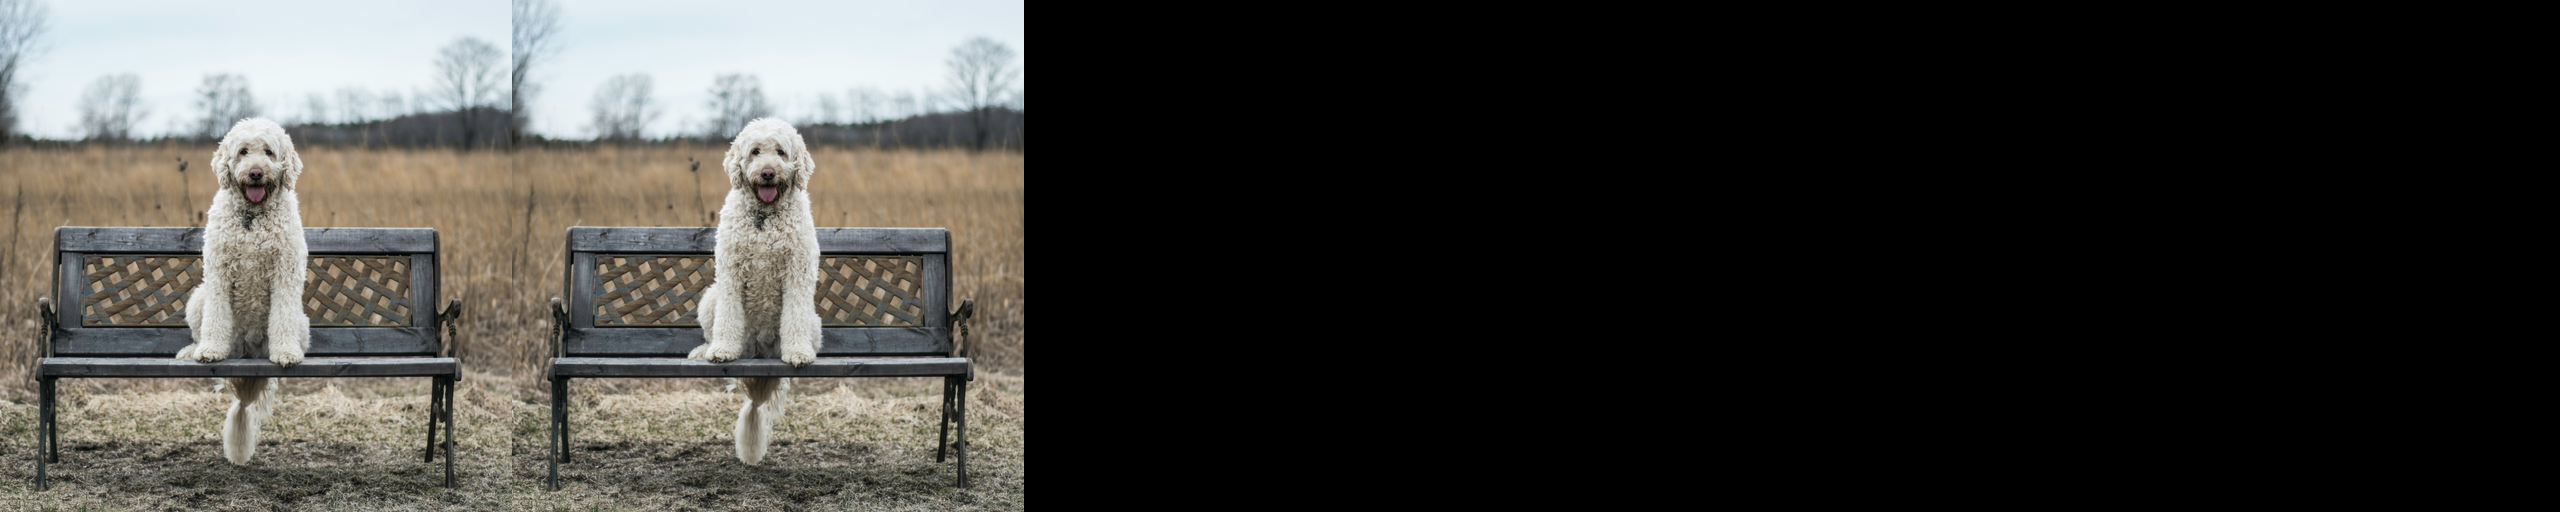

In [ ]:
image_grid(images, 1, num_samples + 1)

### Gradio Demo

In [ ]:
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
  return(images[0])

In [ ]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        gr.Image(sources = 'upload', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=True)